In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 闵可夫斯基距离

In [2]:
def mk_dist(v1, v2, p=2, ax=0):
    """
    Minkowski distance
    """
    return (((v1 - v2)**p).sum(axis=ax))**(1/p)

In [3]:
x5 = np.array([0.556, 0.215])
x1 = np.array([0.697, 0.460])

mk_dist(x1, x5)

0.2826764935398767

# 西瓜数据集4.0

In [4]:
watermelon4 = pd.DataFrame({
    "density":[
         0.697, 0.774, 0.634, 0.608, 0.556, 0.403, 0.481, 0.437, 0.666, 0.243,
         0.245, 0.343, 0.639, 0.657, 0.360, 0.593, 0.719, 0.359, 0.339, 0.282,
         0.748, 0.714, 0.483, 0.478, 0.525, 0.751, 0.532, 0.473, 0.725, 0.446
    ],
    "sugar_content": [
         0.460, 0.376, 0.264, 0.318, 0.215, 0.237, 0.149, 0.211, 0.091, 0.267,
         0.057, 0.099, 0.161, 0.198, 0.370, 0.042, 0.103, 0.188, 0.241, 0.257,
         0.232, 0.346, 0.312, 0.437, 0.369, 0.489, 0.472, 0.376, 0.445, 0.459
    ]
})

watermelon4.index = watermelon4.index+1

In [5]:
watermelon4

,density,sugar_content
1,0.697,0.460
2,0.774,0.376
3,0.634,0.264
4,0.608,0.318
5,0.556,0.215
6,0.403,0.237
7,0.481,0.149
8,0.437,0.211
9,0.666,0.091
10,0.243,0.267


# k-means聚类  
原型聚类

In [17]:
def k_means(df, k):
    """
    k-means clustering
    df:  pd.DataFrame
    k:   number of clusters
    """
    # initial vector mu in ML book
    # df_vector_mu = pd.DataFrame({
    #     "density": [0.403, 0.343, 0.478],
    #     "sugar_content": [0.237, 0.099, 0.437]
    # })

    # initiate vector mu
    df_vector_mu = df.sample(k)
    df_vector_mu.index = range(k)
    # set cluster label for each sample
    cluster_labels = []
    for idx in range(len(df)):
        xi = df.iloc[idx]
        df_dist = mk_dist(xi, df_vector_mu, ax=1)
        label = df_dist.idxmin()
        cluster_labels.append(label)
    df["cluster"] = cluster_labels
    
    # update vector mu
    all_updated = True
    while all_updated:
        update_list = []
        mu_updated = True
        for label in range(k):
            new_mu = df[df["cluster"]==label].iloc[:, :-1].mean()
            # compare pd.Series by s1.equals(s2)
            if df_vector_mu.iloc[label].equals(new_mu):
                mu_updated = False
            else:
                df_vector_mu.iloc[label] = new_mu
                mu_updated = True
            update_list.append(mu_updated)
        
        # check whether all the mu have been updated
        if (sum(update_list) == 0):
            all_updated = False
        else:
            all_updated = True
        
        # update cluster label
        if all_updated:        
            cluster_labels = []
            for idx in range(len(df)):
                xi = df.iloc[idx, :-1]
                df_dist = mk_dist(xi, df_vector_mu, ax=1)
                label = df_dist.idxmin()
                cluster_labels.append(label)
            df["cluster"] = cluster_labels
            
    return df

In [15]:
test = k_means(watermelon4.copy(), 3)
test
# s1, s2 = k_means(watermelon4.copy(), 5)

True
True
True
True
False


,density,sugar_content,cluster
1,0.697,0.460,2
2,0.774,0.376,2
3,0.634,0.264,0
4,0.608,0.318,2
5,0.556,0.215,0
6,0.403,0.237,1
7,0.481,0.149,0
8,0.437,0.211,1
9,0.666,0.091,0
10,0.243,0.267,1


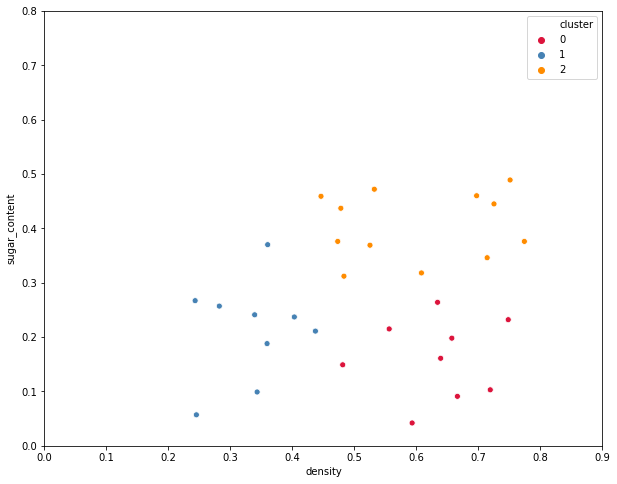

In [29]:
plt.figure(figsize=(10, 8))
colors = {
    0: "#DC143C", 1: "#4682B4", 2:"#FF8C00"
}
sns.scatterplot(x="density", y="sugar_content", hue="cluster", data=test, palette=colors, sizes=20)
plt.xlim([0, 0.9])
plt.ylim([0, 0.8])
plt.show()

# 密度聚类

In [87]:
def core_object(df, epsilon=0.11, min_pts=5):
    cb_idx = set()
    for idx in df.index:
        df_dist = mk_dist(df.loc[idx], df, ax=1)
        pts = (df_dist <= 0.11).sum()
        if pts >= min_pts:
            cb_idx.add(idx)
    return cb_idx


def neighborhood(df, i, epsilon=0.11, min_pts=5):
    df_dist = mk_dist(df.iloc[i], df, ax=1)
    return df[df_dist <= 0.11].index


class Queue(object):
    def __init__(self, lst):
        """
        lst: []
        """
        self.items = lst
    
    def status(self):
        return self.items
    
    def is_empty(self):
        empty = True
        if len(self.items) != 0:
            empty = False
        return empty
    
    def en_queue(self, item):
        return self.items.insert(0, item)
        
    def de_queue(self):
        return self.items.pop()
    
    def size(self):
        return len(self.items)


def dbscan(df, epsilon=0.11, min_pts=5):
    Ck = {}
    cb_idx = core_object(df)

    k = 0
    no_visits = set(df.index)

    while len(cb_idx) != 0:
        no_visits_old = no_visits
        cb = cb_idx.pop()
        queue = Queue([cb,])
        no_visits.discard(cb)
        while (not queue.is_empty()):
            q = queue.de_queue()
            neighbor = neighborhood(df, q)
            if len(neighbor) >= min_pts:
                delta = set(neighbor).intersection(no_visits)
                no_visits.difference(delta)
        k = k + 1
        cluster = no_visits_old.difference(no_visits)
        Ck[k] = cluster
        cb_idx.difference(cluster)
    return Ck

In [88]:
core_object(watermelon4)

{3, 5, 6, 8, 9, 13, 14, 18, 19, 24, 25, 28, 29}

In [89]:
dbscan(watermelon4.copy())

{1: set(),
 2: set(),
 3: set(),
 4: set(),
 5: set(),
 6: set(),
 7: set(),
 8: set(),
 9: set(),
 10: set(),
 11: set(),
 12: set(),
 13: set()}